<a href="https://colab.research.google.com/github/apreshill/pxt-tucci/blob/main/index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pixeltable as pxt
import os
import getpass

# Set OpenAI API key if not already in environment
if 'OPENAI_API_KEY' not in os.environ:
    os.environ['OPENAI_API_KEY'] = getpass.getpass('Enter your OpenAI API key:')

In [ ]:
# Uncomment to clean working space
# pxt.drop_table('my_vids', force=True)

Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata


In [3]:
# Create a table with a video column
t = pxt.create_table('my_vids', schema={'video': pxt.Video}, if_exists='replace_force')

Created table 'my_vids'.


In [4]:
# Insert the tucci-trailer.mp4 video
t.insert([{'video': 'video/tucci-trailer.mp4'}])

Inserting rows into `my_vids`: 1 rows [00:00, 230.14 rows/s]
Inserted 1 row with 0 errors.


1 row inserted, 2 values computed.

In [5]:
t

table 'my_vids'

 Column Name   Type Computed With
       video  Video

video
""

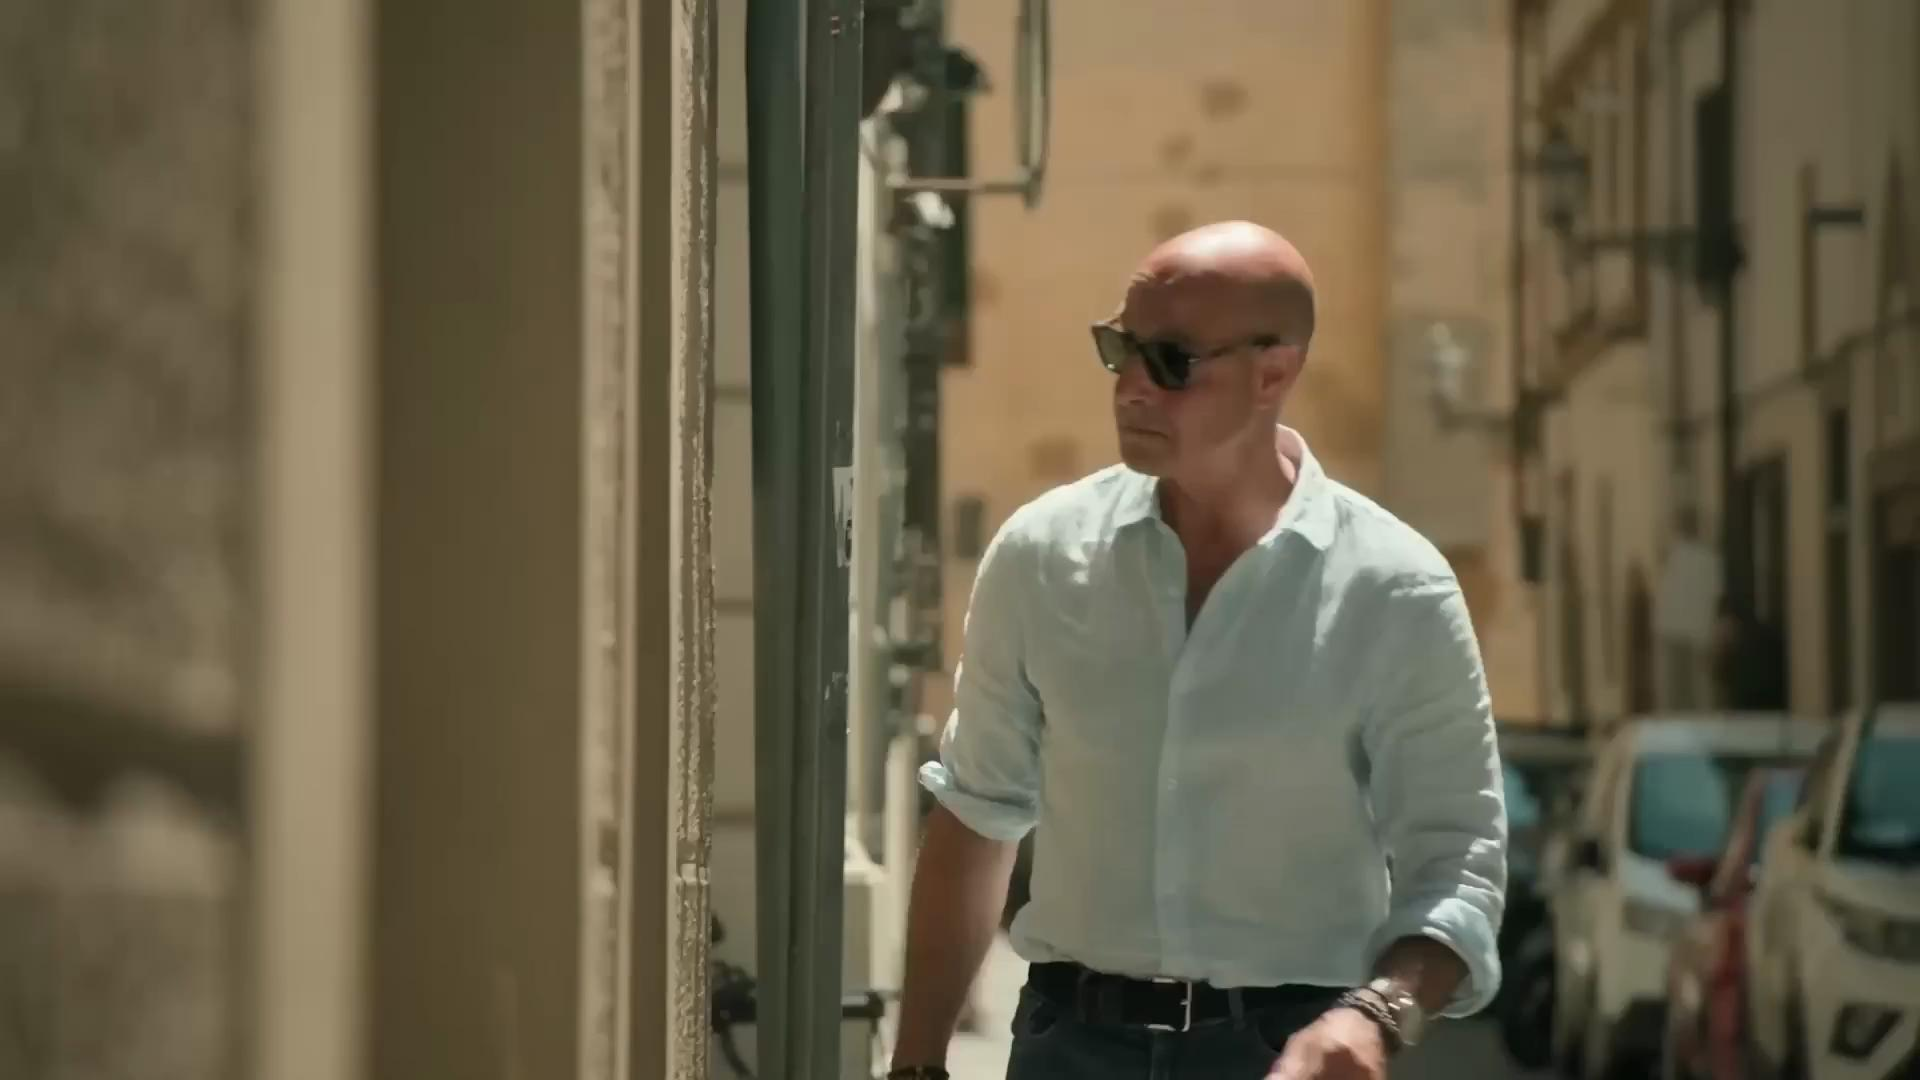

In [6]:
t.collect()

# View 1: Extract audio, then split into 30-second chunks

In [7]:
# get the audio file, save in a column
t.add_computed_column(audio=t.video.extract_audio(format='wav'))

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [8]:
# get the audio metadata, save in a column
t.add_computed_column(audio_md=t.audio.get_metadata())

Added 1 column value with 0 errors.


1 row updated, 1 value computed.

In [9]:
t

table 'my_vids'

 Column Name   Type                      Computed With
       video  Video                                   
       audio  Audio  video.extract_audio(format='wav')
    audio_md   Json               audio.get_metadata()

video,audio,audio_md
,,"{""size"": 21118650, ""streams"": [{""type"": ""audio"", ""frames"": 0, ""duration"": 5279643, ""metadata"": {}, ""time_base"": 2.083e-05, ""codec_context"": {""name"": ""pcm_s16le"", ""profile"": null, ""channels"": 2, ""codec_tag"": ""\\x01\\x00\\x00\\x00""}, ""duration_seconds"": 109.993}], ""bit_rate"": 1536005, ""metadata"": {""encoder"": ""Lavf62.3.100""}, ""bit_exact"": false}"

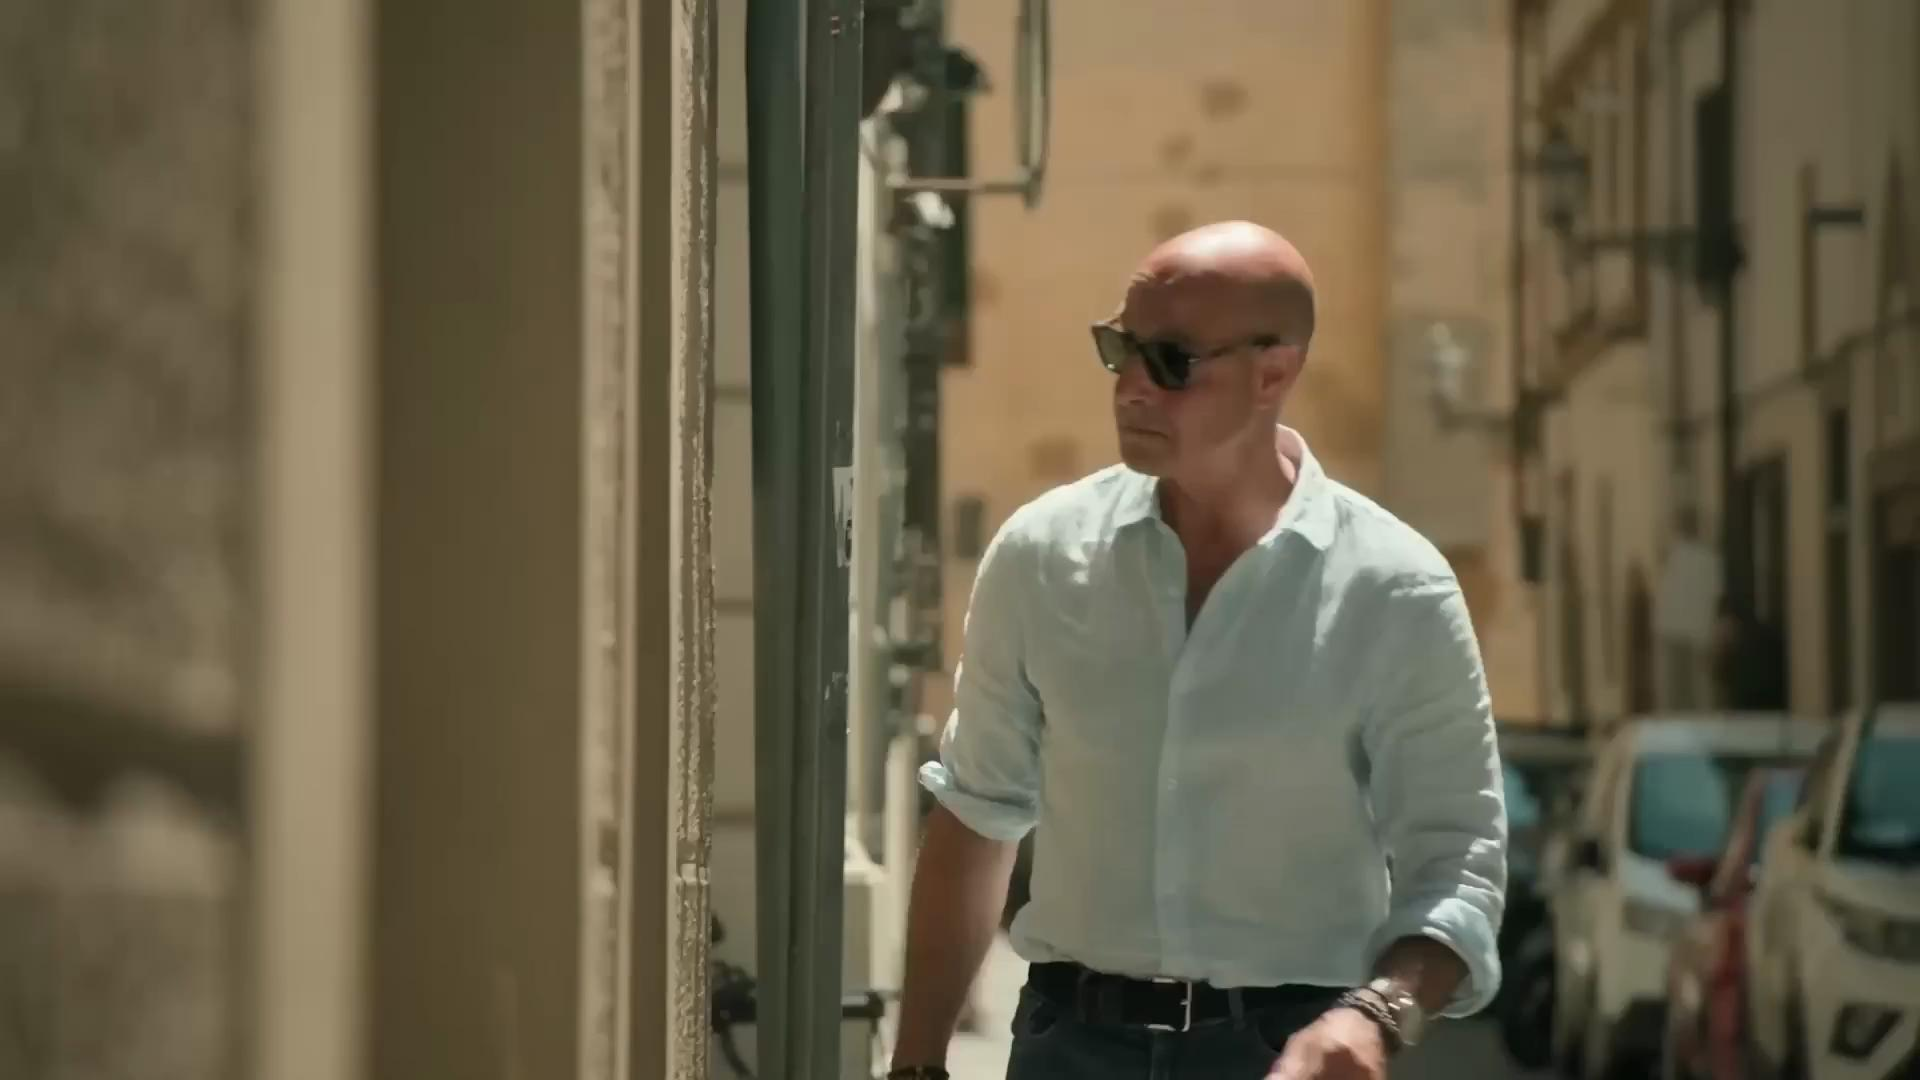

In [10]:
t.collect()

In [11]:
v1 = pxt.create_view(
    'view1',
    t,
    iterator=(
        pxt.iterators.audio.AudioSplitter,
        {
            'audio': t.audio,
            'chunk_duration_sec': 30.0
        }
    )
)

Inserting rows into `view1`: 4 rows [00:00, 1475.70 rows/s]


In [12]:
v1

view 'view1' (of 'my_vids')

     Column Name             Type                      Computed With
             pos    Required[Int]                                   
  start_time_sec  Required[Float]                                   
    end_time_sec  Required[Float]                                   
     audio_chunk            Audio                                   
           video            Video                                   
           audio            Audio  video.extract_audio(format='wav')
        audio_md             Json               audio.get_metadata()

pos,start_time_sec,end_time_sec,audio_chunk,video,audio,audio_md
0,0.,30.037,,,,"{""size"": 21118650, ""streams"": [{""type"": ""audio"", ""frames"": 0, ""duration"": 5279643, ""metadata"": {}, ""time_base"": 2.083e-05, ""codec_context"": {""name"": ""pcm_s16le"", ""profile"": null, ""channels"": 2, ""codec_tag"": ""\\x01\\x00\\x00\\x00""}, ""duration_seconds"": 109.993}], ""bit_rate"": 1536005, ""metadata"": {""encoder"": ""Lavf62.3.100""}, ""bit_exact"": false}"
1,30.,60.037,,,,"{""size"": 21118650, ""streams"": [{""type"": ""audio"", ""frames"": 0, ""duration"": 5279643, ""metadata"": {}, ""time_base"": 2.083e-05, ""codec_context"": {""name"": ""pcm_s16le"", ""profile"": null, ""channels"": 2, ""codec_tag"": ""\\x01\\x00\\x00\\x00""}, ""duration_seconds"": 109.993}], ""bit_rate"": 1536005, ""metadata"": {""encoder"": ""Lavf62.3.100""}, ""bit_exact"": false}"

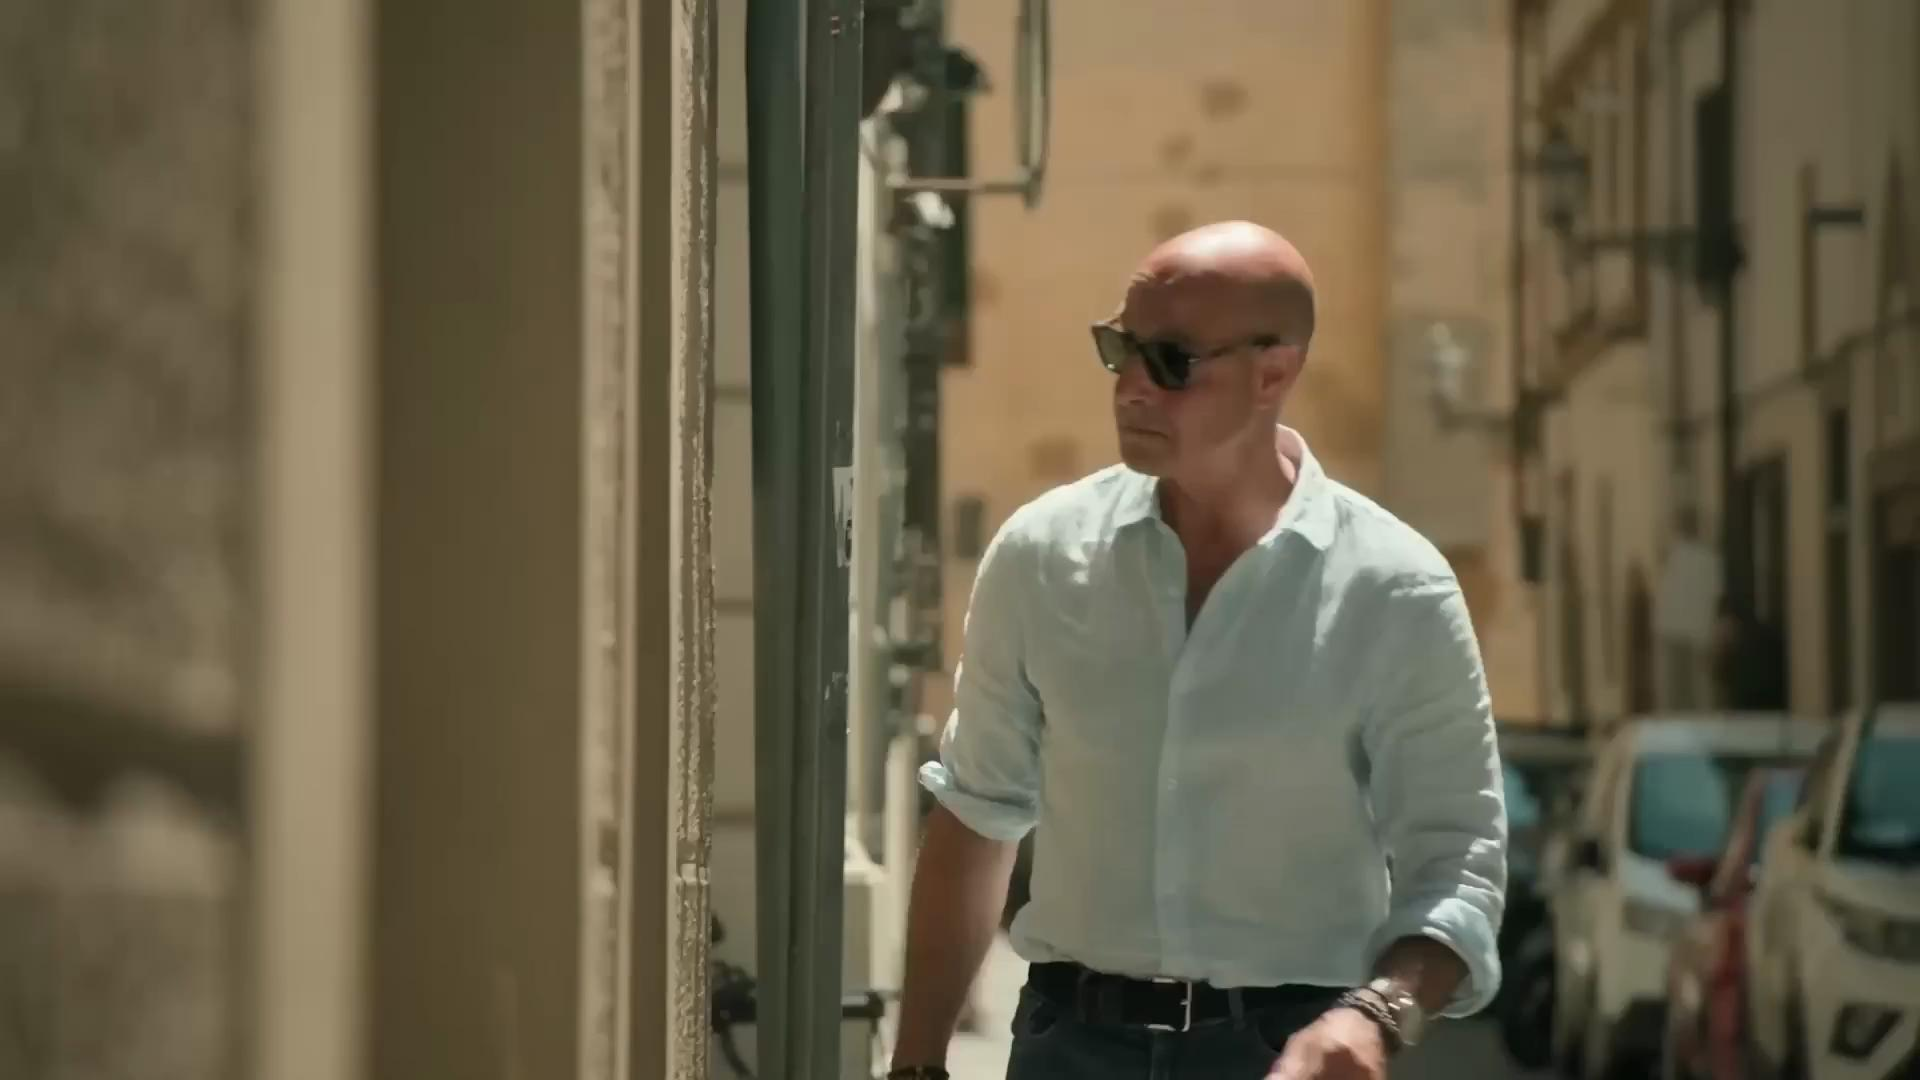
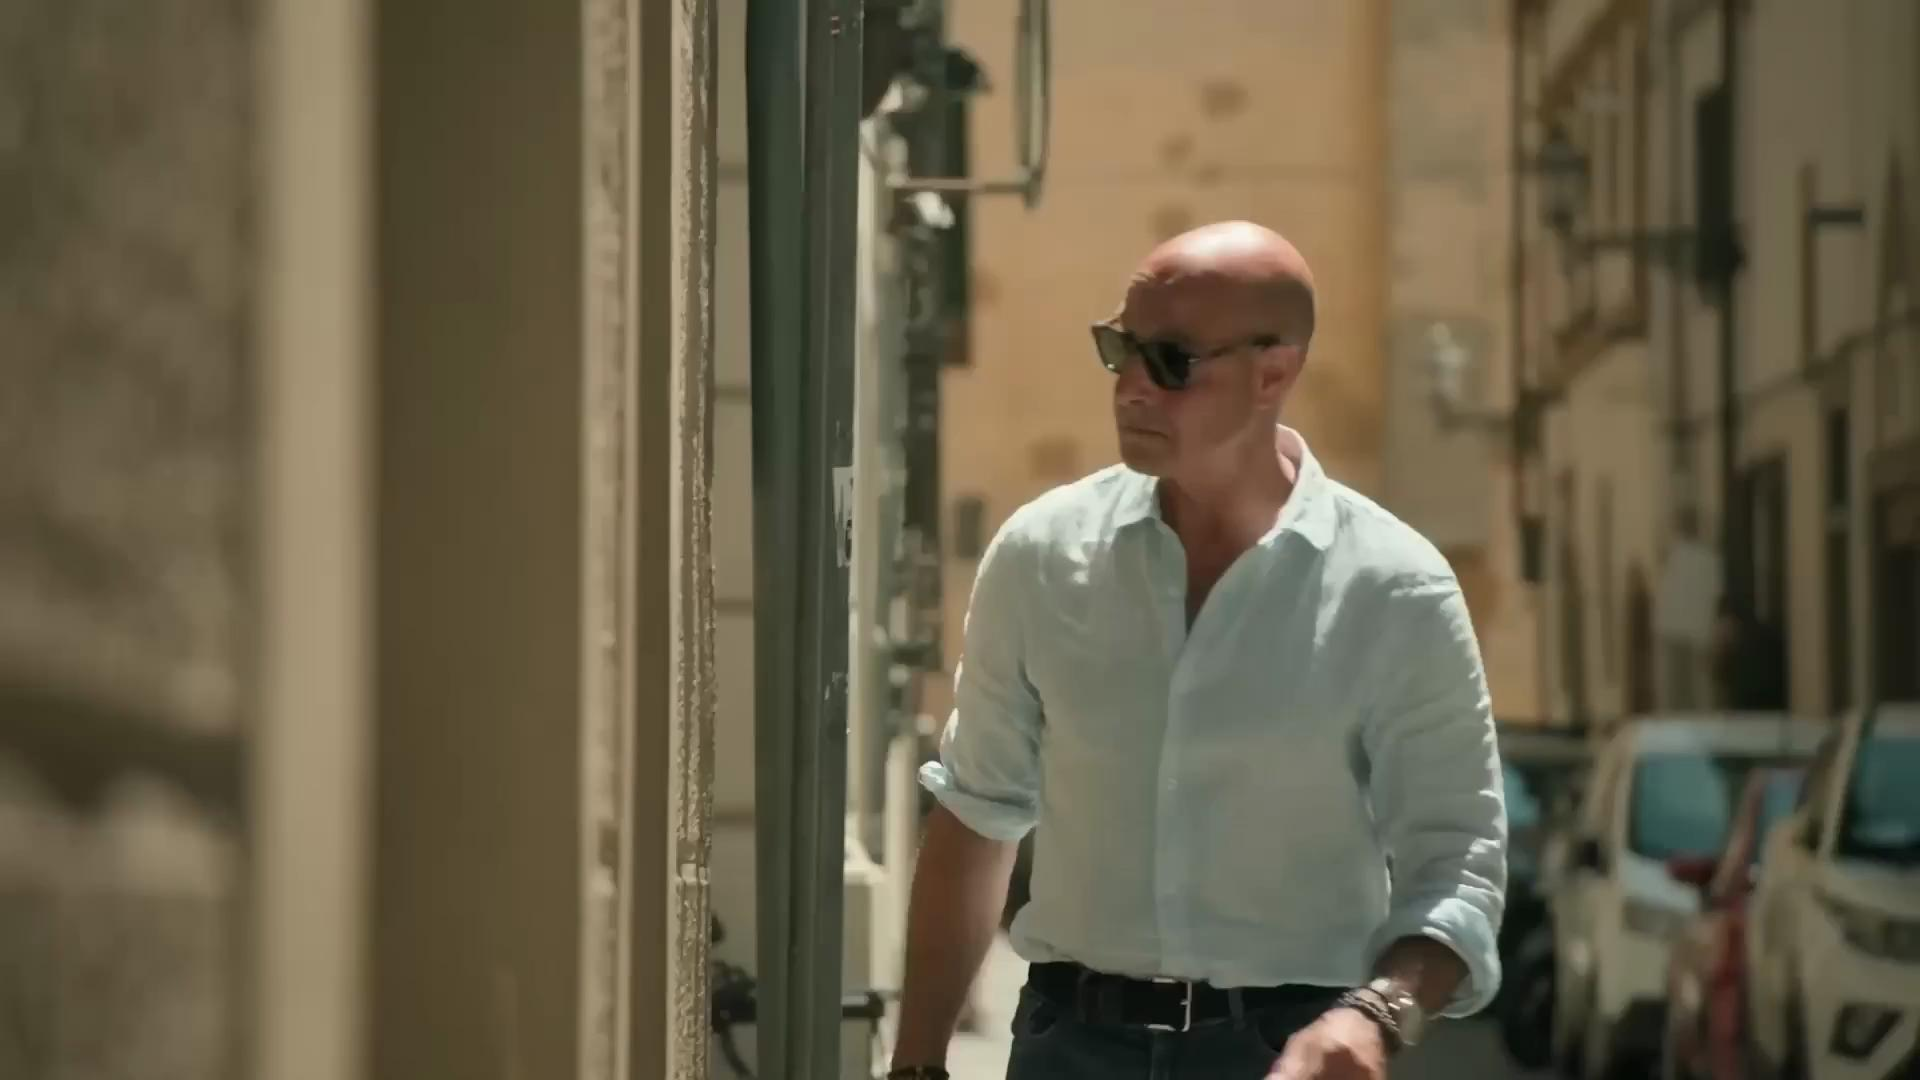

In [13]:
# implict join on the base table so you keep the original context
v1.limit(2).collect()

In [14]:
# show the local path for the audio chunks
v1.select(v1.audio_chunk, v1.audio_chunk.localpath).limit(2).collect()

audio_chunk,audio_chunk_localpath
,/Users/alison-pxt/.pixeltable/media/5dad4d38b6924757aae8e2c1f778b2dc/86/86ca/5dad4d38b6924757aae8e2c1f778b2dc_3_0_86cac89cd63a42178e9f75c071754c08.wav
,/Users/alison-pxt/.pixeltable/media/5dad4d38b6924757aae8e2c1f778b2dc/60/60cb/5dad4d38b6924757aae8e2c1f778b2dc_3_0_60cb4e5bbc414048a89251e439f3d481.wav


In [ ]:
# There is just one `video` & `audio` per view (not per row)
v1.select(v1.video.localpath, v1.audio.localpath).distinct().collect()

video_localpath,audio_localpath
/Users/alison-pxt/Documents/Github/pxt-tucci/video/tucci-trailer.mp4,/Users/alison-pxt/.pixeltable/media/0467e663ae8a4137b6639e1cf5189021/d9/d9af/0467e663ae8a4137b6639e1cf5189021_3_2_d9aff13f9ff94818904457d5bd85016c.wav


## View #2: Transcribe each 30-second audio chunk from view1


In [ ]:
# use openai with our first view to add transcriptions
v1.add_computed_column(transcript=pxt.functions.openai.transcriptions(v1.audio_chunk, model='whisper-1'))

In [ ]:
# Extract text from transcript JSON and cast to String
v1.add_computed_column(transcript_text=v1.transcript.text.astype(pxt.String))

In [ ]:
# check view schema
v1

In [ ]:
# show the transcript text
v1.select(v1.audio_chunk, v1.transcript_text).limit(2).collect()

In [ ]:
# create a view on top of the transcript text, split on sentences
v2 = pxt.create_view(
    'transcript_chunks',
    v1,
    iterator=pxt.iterators.string.StringSplitter.create(
        text=v1.transcript_text,
        separators='sentence'
    ),
    if_exists='replace'
)

# Rename the 'text' column created by StringSplitter to sentence instead
v2.rename_column('text', 'sentence')

In [ ]:
v2

In [ ]:
v2.select(v2.start_time_sec, v2.pos, v2.transcript_text, v2.sentence)\
.order_by(v2_video, v2.start_time_sec)\
.limit(5).collect()

In [ ]:
# Show the first sentence of each audio chunk
v2.where(v2.pos == 0).select(v2.audio_chunk, v2.transcript_text, v2.sentence).collect()

In [ ]:
# add_embedding_index on the sentence column with HF embedding model
from pixeltable.functions.huggingface import sentence_transformer

v2.add_embedding_index(
    v2.sentence,
    embedding=sentence_transformer.using(model_id='sentence-transformers/all-mpnet-base-v2')
)

In [ ]:
v2

In [ ]:
# Basic similarity search
# Search for sentences similar to a query string
query_text = "heritage"
sim = v2.sentence.similarity(query_text)

results = (
    v2.where(sim >= 0.3)  # Minimum similarity threshold
    .order_by(sim, asc=False)  # Order by similarity (highest first)
    .select(v2.sentence, v2.pos, v2.audio_chunk, similarity=sim)
    .limit(5)
    .collect()
)
results

## View #3: Frames

In [ ]:
# frame iterator from t base table, fps 1
v3 = pxt.create_view(
    'frames',
    t,
    iterator=(
        pxt.iterators.video.FrameIterator,
        {
            'video': t.video,
            'fps': 1
        }
    )
)

In [ ]:
v3

In [ ]:
v3.select(v3.frame_idx, v3.pos_msec, v3.frame).limit(5).collect()

In [ ]:
# DETR object detection on frames
from pixeltable.functions.huggingface import detr_for_object_detection

v3.add_computed_column(
    detections=detr_for_object_detection(
        v3.frame,
        model_id='facebook/detr-resnet-50',
        threshold=0.5
    )
)

In [ ]:
v3

In [ ]:
# Add CLIP embedding index on the frame column for multimodal search
from pixeltable.functions.huggingface import clip

v3.add_embedding_index(
    v3.frame,
    embedding=clip.using(model_id='openai/clip-vit-base-patch32')
)

## Multimodal Search with CLIP

Now that we have a CLIP embedding index on the frames, we can perform powerful multimodal searches:
- **Image-to-image search**: Find frames similar to a specific frame
- **Text-to-image search**: Find frames matching text descriptions (e.g., "a person walking", "a car")
- **Combined search**: Combine similarity search with object detection results

**Tip**: Browse frames to find one you want to use for similarity search. Change `frame_pos` in the next cell to select a different frame.


In [ ]:
# Browse frames to find one you want to use
browse_start = 75
browse_end = 80

browse_frames = (
    v3.where((v3.pos >= browse_start) & (v3.pos < browse_end))
    .select(v3.frame, v3.pos)
    .collect()
)
browse_frames


In [ ]:
# Example 1: Image-to-image similarity search
frame_pos = 78  # Change this to select a different frame (0-109 for 110 frames at 1 fps)
sample_frame = v3.where(v3.pos == frame_pos).select(v3.frame).collect()[0]['frame']
sample_frame

In [ ]:
# Find frames similar to the sample frame
sim = v3.frame.similarity(sample_frame)
similar_frames = (
    v3.order_by(sim, asc=False)
    .limit(5)
    .select(v3.frame, v3.pos, similarity=sim)
    .collect()
)
similar_frames

In [ ]:
# Example 2: Text-to-image search (multimodal!)
# Search for frames matching text descriptions
query_text = "pasta"  # Try 'wine', 'street', 'pizza'
sim = v3.frame.similarity(query_text)

text_search_results = (
    v3.order_by(sim, asc=False)
    .limit(5)
    .select(v3.frame, v3.pos, similarity=sim)
    .collect()
)
text_search_results
